In [1]:
import os

In [2]:
%pwd

'd:\\college_work\\4th year\\Sem7th\\Project\\MLOPS\\MLOPS-Wine-Quality-Prediction\\research'

In [3]:
print(f"current dir")
curr_dir = %pwd
print(f"{curr_dir}")

print('\n')
print(f"project dir")
os.chdir("../")
%pwd

current dir
d:\college_work\4th year\Sem7th\Project\MLOPS\MLOPS-Wine-Quality-Prediction\research


project dir


'd:\\college_work\\4th year\\Sem7th\\Project\\MLOPS\\MLOPS-Wine-Quality-Prediction'

Entity crateation 

creating some datatype classes for the ahead uses

In [4]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path
    clean_data: Path

Creating the configuration manager 

assiging and accessing the config.yaml elements 

In [5]:
from mlproject.constants import *  
from mlproject.utils.common import create_directories,read_yaml

In [6]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,  
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config.artifacts_root])
        
    def get_data_transfomation_config(self)-> DataTransformationConfig:
        config = self.config.data_transformation
        
        create_directories([config.root_dir])
        
        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
            clean_data=config.clean_data
        )
        return data_transformation_config

Adding the components read below:

here you can do all your preprocessing of the dataset and after create train and test here only and save them in the seprate csv files

In [7]:
from mlproject import logger
import os
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

Doing the cleaning of data

## Cleaning of data

### Creating data profile generater

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
!pip install ydata-profiling

In [65]:
from ydata_profiling import ProfileReport

def gen_profile(dataframe, name:str):
    profile = ProfileReport(dataframe,title=name,dark_mode=True)
    profile.to_file(f"{name}.html")

c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Accessing the data

In [16]:
# %%timeit
pd.option_context('mode.use_inf_as_na', True)
df = pd.read_csv("../artifacts/data_ingestion/wine-quality.csv")

1.15 ms ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
df

,category,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.4,0.70,0.00,1.90,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,1,7.8,0.88,0.00,2.60,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,1,7.8,0.76,0.04,2.30,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,1,11.2,0.28,0.56,1.90,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
4,1,7.4,0.70,0.00,1.90,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6643,0,7.1,0.23,0.35,16.50,0.040,60.0,171.0,0.9990,3.16,0.59,9.1,6.0
6644,0,6.9,0.33,0.28,1.30,0.051,37.0,187.0,0.9927,3.27,0.60,10.3,5.0
6645,0,6.5,0.17,0.54,8.50,0.082,64.0,163.0,0.9959,2.89,0.39,8.8,6.0
6646,0,7.2,0.27,0.46,18.75,0.052,45.0,255.0,1.0000,3.04,0.52,8.9,5.0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6648 entries, 0 to 6647
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   category              6648 non-null   object 
 1   fixed acidity         6648 non-null   float64
 2   volatile acidity      6648 non-null   float64
 3   citric acid           6648 non-null   float64
 4   residual sugar        6648 non-null   float64
 5   chlorides             6642 non-null   float64
 6   free sulfur dioxide   6630 non-null   float64
 7   total sulfur dioxide  6648 non-null   float64
 8   density               6638 non-null   float64
 9   pH                    6648 non-null   float64
 10  sulphates             6639 non-null   float64
 11  alcohol               6648 non-null   float64
 12  quality               6639 non-null   float64
dtypes: float64(12), object(1)
memory usage: 675.3+ KB


- we have some null valus
- we have category in obje form 


+ fill null with mean or media

### Dealing the null data

In [47]:
df.isna().sum()

category                 0
fixed acidity            0
volatile acidity         0
citric acid              0
residual sugar           0
chlorides                6
free sulfur dioxide     18
total sulfur dioxide     0
density                 10
pH                       0
sulphates                9
alcohol                  0
quality                  9
dtype: int64

replacing the null palces with the median and mode

count    6639.000000
mean        5.864739
std        19.421882
min      -876.000000
25%         5.000000
50%         6.000000
75%         6.000000
max       555.000000
Name: quality, dtype: float64


<Axes: xlabel='quality'>

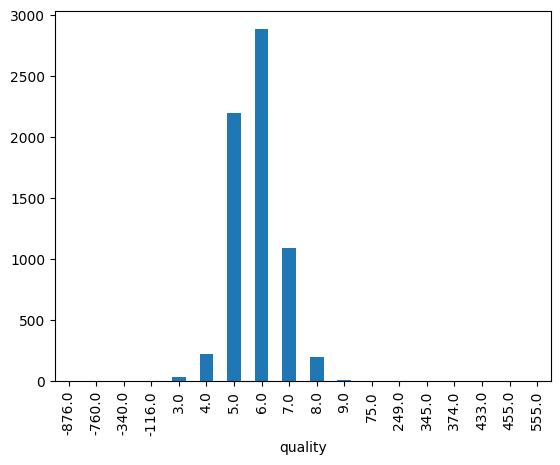

In [21]:
print(df['quality'].describe())
df.groupby('quality').size().plot(kind='bar')

In [3]:
df['chlorides'] = df['chlorides'].fillna(df['chlorides'].mean())
df['sulphates'] = df['sulphates'].fillna(df['sulphates'].mean())
df['density'] = df['density'].fillna(df['density'].mean())
df['free sulfur dioxide'] = df['free sulfur dioxide'].fillna(df['free sulfur dioxide'].mode()[0])
df['quality'] = df['quality'].fillna(df['quality'].mode()[0])


In [51]:
df.isna().sum()

category                0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [30]:
df.isnull().sum()

category                0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Droping duplicates and nan values

In [4]:
print(df.shape)
df=df.drop_duplicates()
print(df.shape)


(6648, 13)
(5381, 13)


### Handling Outliers and data transformation

#### Plots

try to plot and show the skewness of data 

In [61]:
# df_1 = df[['category', 'fixed acidity','volatile acidity',  'residual sugar','chlorides' ]]
# df_2 = df[['free sulfur dioxide','total sulfur dioxide', 'pH',  'alcohol','sulphates','quality' ]]
# df_3 = df[['citric acid','density']]

In [62]:
# num_rows2 = (len(df_2.columns) + 2)//3

# fig, axes = plt.subplots(nrows=num_rows2,ncols=3,figsize=(20,10*num_rows2))
# axes = axes.flatten()
# for i, column in enumerate(df_2.columns):
#     sns.histplot(data=df_2,x=column,kde=True,ax=axes[i])
#     axes[i].set_title(f'Histogram of {column}')
    
# plt.tight_layout()
# plt.show()

c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


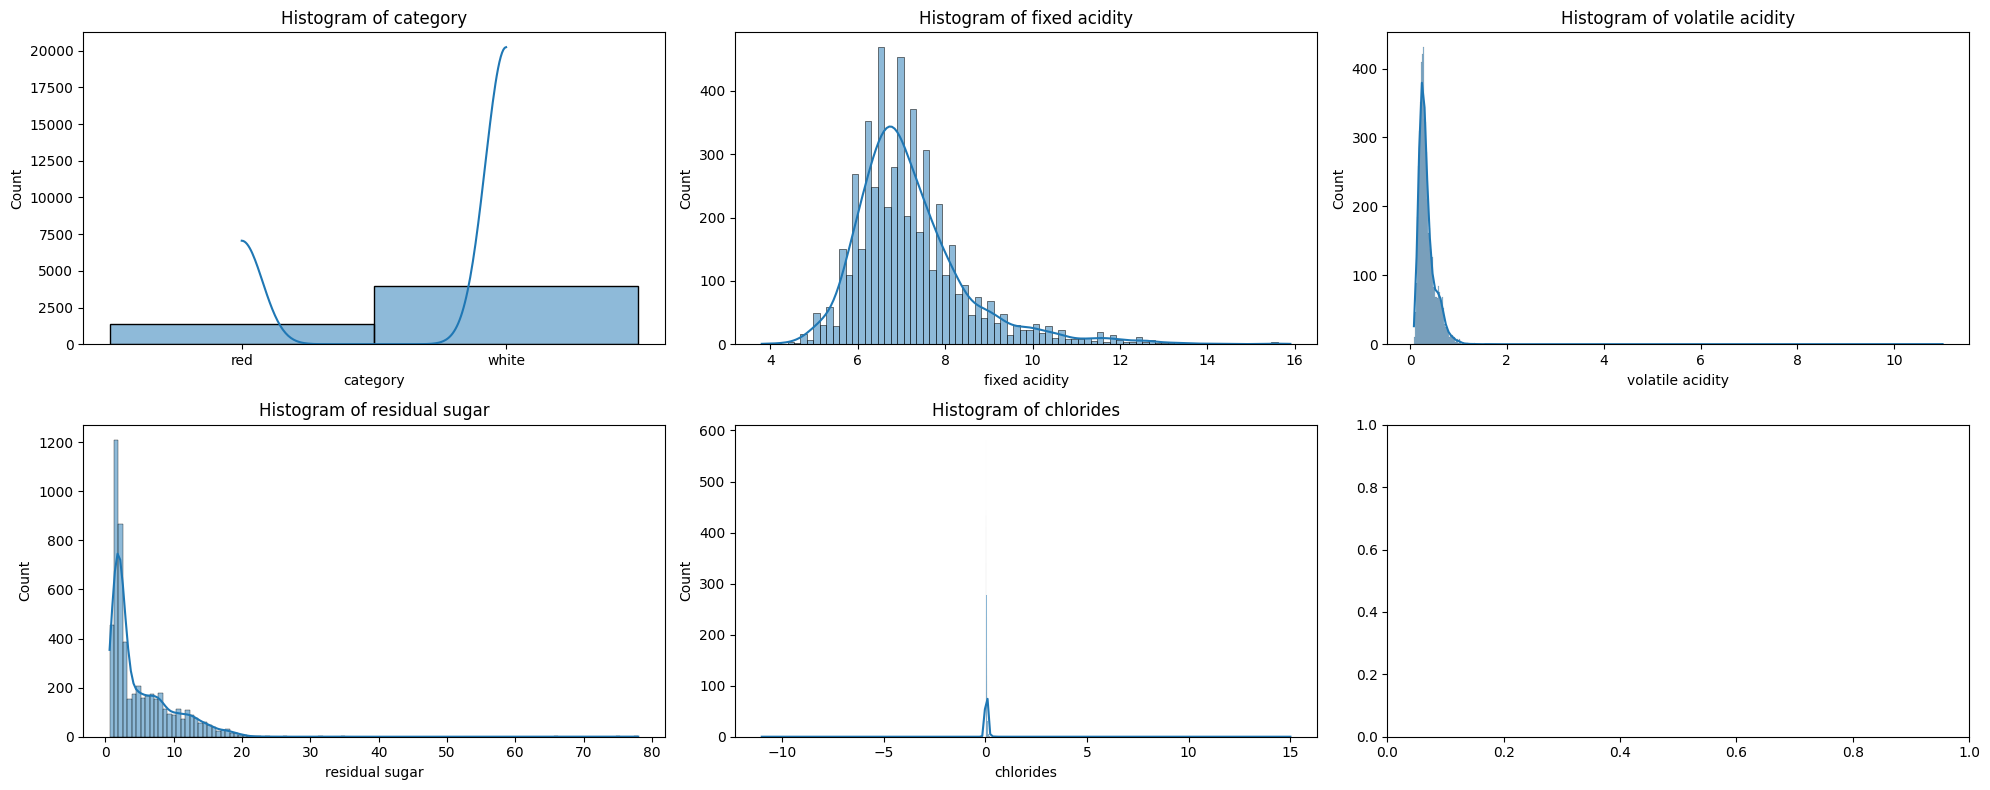

In [63]:
columns_to = df_1.columns
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(20,8))
axes = axes.flatten()

for i,column in enumerate(columns_to):
    sns.histplot(data=df_1,x=column,kde=True,ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    
    
plt.tight_layout()
plt.show()

## as above doing the log transformation for removing the below written data columns

# fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,8))
# axes = axes.flatten()

# for i,col in enumerate(skewed_col):
#     sns.histplot(data=df,x=col,ax=axes[i],kde=True)
#     axes[i].set_title(f'Histogram of {col}')
    
# plt.tight_layout()
# # plt.show()

c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

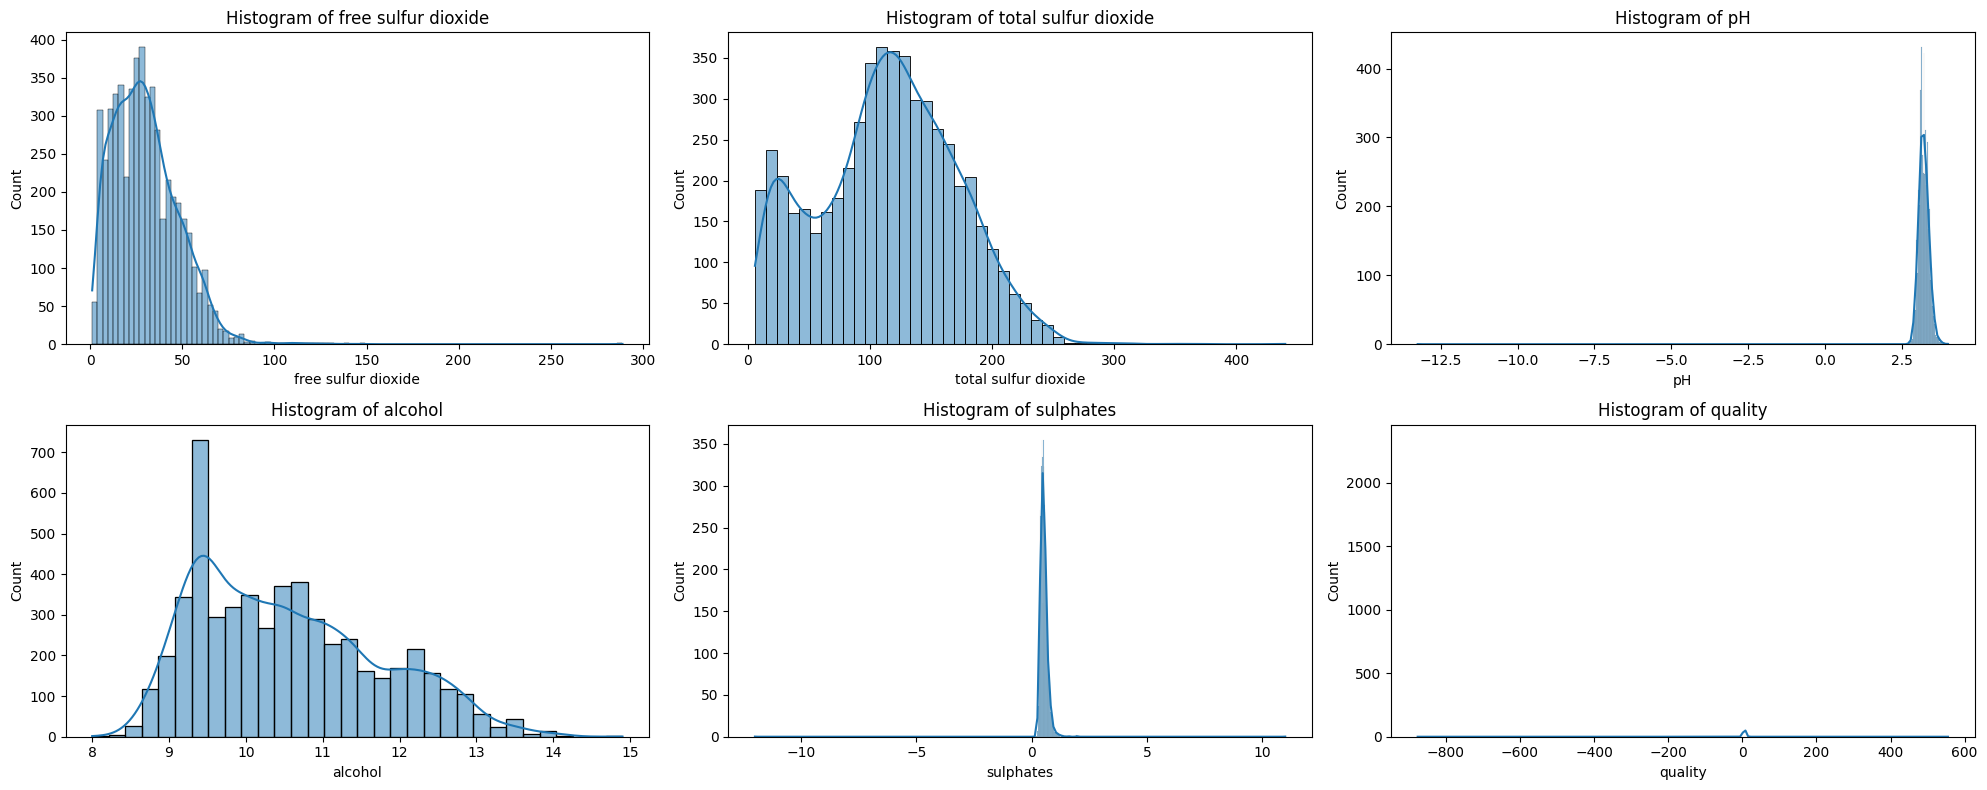

In [64]:
columns_to = df_2.columns
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(20,8))
axes = axes.flatten()

for i,column in enumerate(columns_to):
    sns.histplot(data=df_2,x=column,kde=True,ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    
plt.tight_layout()
plt.show()

### Transformation Method

1. Log Transformation 

**when to use** 
- right skewed 
- also when range value varies widely


2. Square Root Transformation

**when to use**
- right skewed data 
- 

### doing transformation

In [5]:
from scipy.stats import skew,boxcox

skewed_col = ['volatile acidity', 'citric acid', 'pH', 'density', 'chlorides']
skew_df = pd.DataFrame(columns=skewed_col,index=['original','log','square_root','boxcox','cube_root','exponential'])

def skewness_cal(data):
    n  = len(data)
    mean = data.mean()
    std = data.std()
    skewness = (n/((n-1)*(n-2)))* np.sum(((data - mean)/std) ** 3)
    return skewness 

## comparing the results of the both type of transformation log and squared 
def compare_trans(data):
    log_trans = np.log1p(data)
    sqr_trans = np.sqrt(data)
    expon_trans = np.exp(data)
    cube_root = np.cbrt(data)
    # boxcox_trans ,_ = boxcox(data + 1) # issue with the zero values as boxcox do not consider the zero and negative values
    boxcox_trans = np.array([1,2,3,4,5,6])
    return log_trans,sqr_trans,expon_trans,boxcox_trans,cube_root

for i,col in enumerate(skewed_col):
    skewness = skewness_cal(df[col])
    skew_df[col]['original'] = skewness
    # print(f"column name: {col} and its skewness with scipy.stats {skewness}")

for i,col in enumerate(skewed_col):
    log_trans,sqr_trans,expon_trans,boxcox_trans,cube_root = compare_trans(df[col])
    skew_df[col]['log'] = skewness_cal(log_trans)
    skew_df[col]['square_root'] = skewness_cal(sqr_trans)
    skew_df[col]['exponential'] = skewness_cal(expon_trans)
    skew_df[col]['cube_root'] = skewness_cal(cube_root)
    skew_df[col]['boxcox'] = skewness_cal(boxcox_trans)
    
    
# adding the changes in the final data 
for i,col in enumerate(skewed_col[:4]):
    df[col] = np.log1p(df[col])
    

## applying the cube root transformation to chlorides 
df['chlorides'] = np.cbrt(df['chlorides'])

    
# print(f"I applied the log transformation to the following cols \n {skewed_col[:4]}")
# print("\n The comparison of different transformation is below")
display(skew_df)

c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Ukant\anaconda3\envs\mlops\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,volatile acidity,citric acid,pH,density,chlorides
original,16.866122,-33.220155,-39.411621,65.935504,17.164795
log,3.318598,9.30254,0.26722,38.720687,29.625887
square_root,4.114134,15.220552,0.310741,50.174411,22.820968
boxcox,0.0,0.0,0.0,0.0,0.0
cube_root,-1.132988,-8.21884,-54.621013,44.522466,-1.873427
exponential,73.318841,73.3553,0.975945,0.0,63.623777


### Handling the zero of the col ```citric acid```

we are having 137 zeros out of 5381


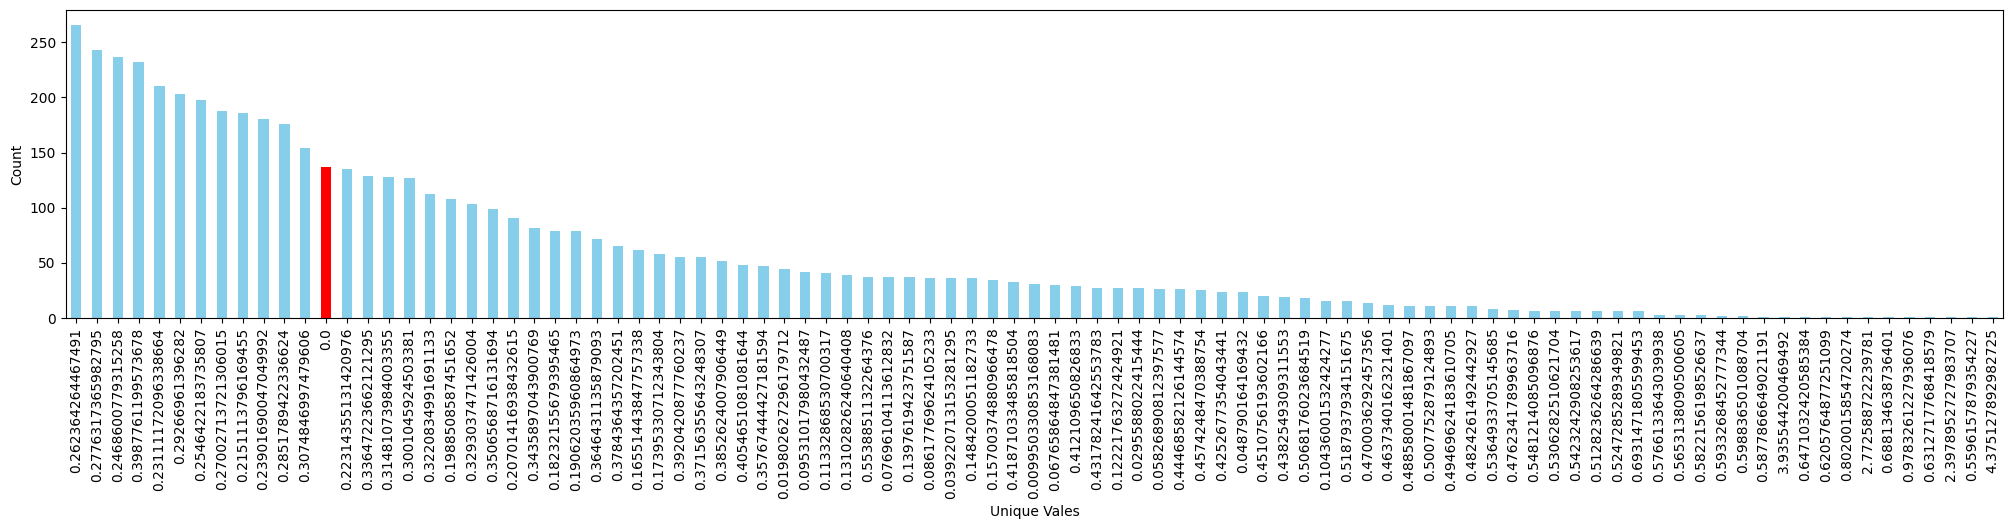

droping the rows containing value 0.0 new shape of data
 (5244, 13)


In [8]:
value_count = df['citric acid'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(25,4))
bar_plot = value_count.plot(kind='bar',color='skyblue')
if 0 in value_count.index:
    zero_index = value_count.index.get_loc(0)
    print(f"we are having {value_count.values[zero_index]} zeros out of {df['citric acid'].shape[0]}")
    bar_plot.patches[zero_index].set_facecolor('red')
plt.xlabel('Unique Vales')
plt.ylabel('Count')
plt.show()
df.drop(df[df['citric acid'] == 0].index, inplace= True)
df.reset_index(drop=True,inplace=True)
print(f'droping the rows containing value 0.0 new shape of data\n {df.shape}')

### Handling the quality column

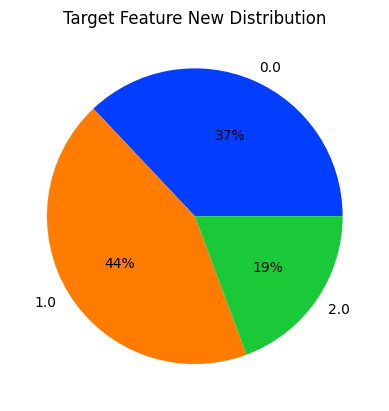

In [9]:
low = np.unique(df[df['quality'] <= 5]['quality'].values)
average = np.unique(df[df['quality'] == 6]['quality'].values)
high = np.unique(df[df['quality'] >= 7]['quality'].values)


df['quality'] = df['quality'].replace(low,0)
df['quality'] = df['quality'].replace(average,1)
df['quality'] = df['quality'].replace(high,2)


palette_color = sns.color_palette('bright')
  
# plotting data on chart
plt.pie(df.groupby('quality').size().values, labels=df.groupby('quality').size().index, colors=palette_color, autopct='%.0f%%')

plt.title("Target Feature New Distribution")
# displaying chart
plt.show()

In [15]:
%%timeit
df['category'] = np.where(df['category'] == "white",0,1)

%%timeit
df['category'] = df['category'].map({'red':0,'white':1})

178 µs ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Nomalization

In [10]:
display(df.isna().sum())
print(f"During transformation some values are nan and null as they are very small in size we can drop them")
df=df.dropna(axis=0)
df.isna().sum()

category                0
fixed acidity           0
volatile acidity        1
citric acid             4
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      1
sulphates               0
alcohol                 0
quality                 0
dtype: int64

During transformation some values are nan and null as they are very small in size we can drop them


category                0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Doing the zscore nomalization due to outliers and exception in the dataset

In [19]:
from sklearn.preprocessing import StandardScaler
from pathlib import Path
scaler = StandardScaler()
col_num = df.select_dtypes(include=['float64','int64']).columns
df[col_num] = scaler.fit_transform(df[col_num])
df.to_csv((Path("../artifacts/data_transformation/clean-wine-quality.csv")))
df.head()

,category,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,red,0.433583,2.325168,-1.760494,-0.597940,0.919305,-0.862347,-1.103888,-0.018165,0.277821,0.431953,-0.624408,-1.128330
1,red,3.002327,-0.311791,1.211268,-0.682013,0.566869,-0.750222,-0.996742,-0.014147,-0.364215,0.174741,-0.624408,0.242944
2,red,0.509135,1.535952,-1.620885,-0.745067,0.429784,-0.862347,-1.014600,-0.020577,0.530425,-0.266193,-0.961878,-1.128330
3,red,0.433583,1.431793,-1.902814,-0.660995,0.522014,-1.198724,-1.746760,-0.018969,0.904959,0.137997,-0.877510,1.614218
4,red,0.206929,1.001540,0.205684,0.200747,0.476332,-0.750222,-0.246725,-0.014950,0.842896,0.983121,-0.033835,-1.128330


### Known issue in the datase 

1. skewness of two columns is yet high col name [density,chlorides]
2. 

## Progression code

In [8]:
class DataTransformation:
    def __init__(self, config:DataTransformationConfig):
        self.config = config
        
        
    # def data_access(self):
    #     df = pd.read_csv(self.config.data_path)
    #     logger.info(f"Data shape {df.shape}")
    #     return df
    
    def preprocessing(self):
        df = pd.read_csv(self.config.data_path)
        logger.info(f"Data shape {df.shape}")
        
        # Handling nan values 
        df['chlorides'] = df['chlorides'].fillna(df['chlorides'].mean())
        df['sulphates'] = df['sulphates'].fillna(df['sulphates'].mean())
        df['density'] = df['density'].fillna(df['density'].mean())
        df['free sulfur dioxide'] = df['free sulfur dioxide'].fillna(df['free sulfur dioxide'].mode()[0])
        df['quality'] = df['quality'].fillna(df['quality'].mode()[0])
        
        # Droping the duplicate values 
        df=df.drop_duplicates()
        
        # Transformation Handling the skewness of data 
        skewed_col = ['volatile acidity', 'citric acid', 'pH', 'density', 'chlorides'] # col with high skewness
        for i,col in enumerate(skewed_col[:4]):
            # df[col] = np.log1p(df[col])
            df[col] = df[col].apply(lambda x: np.log1p(x))
        df[skewed_col[-1]] = df[skewed_col[-1]].apply(lambda x: np.cbrt(x))
        # df[skewed_col[-1]] = np.cbrt(skewed_col[-1])
        
        # col Citric acid has some amount(134 out of 5381) of zeros(0.0)  so dropping them also 
        df.drop(df[df['citric acid'] == 0].index, inplace= True)
        df.reset_index(drop=True,inplace=True)
        
        # Making quality column more accurate 
        low = np.unique(df[df['quality'] <= 5]['quality'].values)
        average = np.unique(df[df['quality'] == 6]['quality'].values)
        high = np.unique(df[df['quality'] >= 7]['quality'].values)
        df['quality'] = df['quality'].replace(low,0)
        df['quality'] = df['quality'].replace(average,1)
        df['quality'] = df['quality'].replace(high,2)
        
        df=df.dropna(axis=0)
        
        # normalizing with z score method
        scaler = StandardScaler()
        col_num = df.select_dtypes(include=['float64','int64']).columns
        df[col_num] = scaler.fit_transform(df[col_num])
        
        logger.info(f"Data shape after preprocessing {df.shape}")
        
        # saving the cleaned data
        df.to_csv(os.path.join(self.config.root_dir,"clean-wine-quality.csv"),index=False)
        
        
        
    def train_test_spliting(self):
        data = pd.read_csv(self.config.clean_data)
        train, test = train_test_split(data)
        
        train.to_csv(os.path.join(self.config.root_dir,"train.csv"),index=False)
        test.to_csv(os.path.join(self.config.root_dir,"test.csv"),index=False)
        
        logger.info("Splited data into training and testing sets")
        logger.info(train.shape)
        logger.info(test.shape)
        
        print(train.shape)
        print(test.shape)

Create the pipe line by connecting all three

In [9]:
try: 
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transfomation_config()
    data_transfomation = DataTransformation(config=data_transformation_config)
    data_transfomation.preprocessing()
    data_transfomation.train_test_spliting()
except Exception as e:
    raise e

[2023-12-12 17:14:09,293: INFO: common: yaml file: config\config.yaml loaded successfully]
[2023-12-12 17:14:09,308: INFO: common: yaml file: params.yaml loaded successfully]
[2023-12-12 17:14:09,321: INFO: common: yaml file: schema.yaml loaded successfully]
[2023-12-12 17:14:09,322: INFO: common: created directory at: artifacts]
[2023-12-12 17:14:09,324: INFO: common: created directory at: artifacts/data_transformation]
[2023-12-12 17:14:09,370: INFO: 766621878: Data shape (6648, 13)]
[2023-12-12 17:14:09,481: INFO: 766621878: Data shape after preprocessing (5238, 13)]


C:\Users\Ukant\AppData\Local\Temp\ipykernel_11772\766621878.py:29: RuntimeWarning: invalid value encountered in log1p
  df[col] = df[col].apply(lambda x: np.log1p(x))


[2023-12-12 17:14:09,784: INFO: 766621878: Splited data into training and testing sets]
[2023-12-12 17:14:09,785: INFO: 766621878: (3928, 13)]
[2023-12-12 17:14:09,786: INFO: 766621878: (1310, 13)]
(3928, 13)
(1310, 13)
